In [50]:
from pathlib import Path
from typing import Iterable, List, Optional, Callable
import matplotlib.pyplot as plt

import rasterio as rio

from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from torchgeo.samplers import RandomGeoSampler, Units
from torchgeo.transforms import indices
from torch.utils.data import DataLoader
import torch
from tqdm.auto import tqdm
import segmentation_models_pytorch as smp
from dvclive import Live

In [51]:
%load_ext watermark
%watermark -v -m --iversions

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
CPU cores   : 12
Architecture: 64bit

matplotlib                 : 3.5.2
torchseg                   : 0.0.1a4
rasterio                   : 1.3.10
segmentation_models_pytorch: 0.3.3
kornia                     : 0.7.2
schedulefree               : 1.2.7
torchgeo                   : 0.5.2
numpy                      : 1.23.1
torch                      : 2.4.0.dev20240405+cu121



In [146]:
import torch
from flipnslide.tiling import FlipnSlide
from typing import Any
from torch import Tensor
import kornia as K
class _FlipnSlide(K.augmentation.GeometricAugmentationBase2D):
    """Flip and slide a tensor."""

    def __init__(self, tilesize: int, viz: bool = False) -> None:
        """Initialize a new _FlipnSlide instance.

        Args:
            tilesize: desired tile size
            viz: visualization flag
        """
        super().__init__(same_on_batch = True, p=1)
        self.flags = {'tilesize': tilesize, 'viz': viz}

    def compute_transformation(
        self, input: Tensor, params: dict[str, Tensor], flags: dict[str, Any]
    ) -> Tensor:
        """Compute the transformation.

        Args:
            input: the input tensor
            params: generated parameters
            flags: static parameters

        Returns:
            the transformation
        """
        
        out: Tensor = self.identity_matrix(input)
        return out

    def apply_transform(
        self,
        input: Tensor,
        params: dict[str, Tensor],
        flags: dict[str, Any],
        transform: Tensor = None,
    ) -> Tensor:
        """Apply the transform.

        Args:
            input: the input tensor
            params: generated parameters
            flags: static parameters
            transform: the geometric transformation tensor

        Returns:
            the augmented input
        """
        np_array = input.squeeze(0).cpu().numpy()
        sample_tiled = FlipnSlide(
            tile_size=flags['tilesize'], 
            data_type='tensor',
            save=False, 
            image=np_array,
            viz=flags['viz']
        )
        return sample_tiled.tiles

In [151]:
from torchgeo.transforms import AugmentationSequential
# Usage with AugmentationSequential
flipnslide = _FlipnSlide(tilesize=128, viz=False)
tfms = AugmentationSequential(
    flipnslide,
    data_keys= ['image', 'mask']
)

tfms_img = AugmentationSequential(
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)

In [178]:
# Example usage
train_batch = {
    'image': torch.rand(1, 11, 256, 256),
    'mask': torch.rand(1, 1, 256, 256),
    'crs': [],
    'bbox': []
}
batch_tfms = [tfms, tfms_img]
if batch_tfms is not None:
    transformed = [tfm(train_batch) for tfm in batch_tfms][0]
#transformed = tfms(tfms_img(train_batch))

print("Transformed image shape:", transformed['image'].shape)
print("Transformed mask shape:", transformed['mask'].shape)

Transformed image shape: torch.Size([10, 13, 128, 128])
Transformed mask shape: torch.Size([10, 128, 128])


# Visualise a single image

In [52]:
from pathlib import  Path
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt

# root = Path(r"C:\Users\coach\myfiles\postdoc\Fire\data\indonesia\fire_data")
root = Path(r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN")
assert root.exists()

# train_imgs = list((root/'images').glob('*.tif'))
# train_masks = list((root/'masks').glob('*.tif'))
train_imgs = list((root/'X').glob('*.tif'))
train_masks = list((root/'Y').glob('*.tif'))

# As the images and corresponding masks are matched by name, we will sort both lists to keep them synchronized.
train_imgs.sort(); train_masks.sort()

In [53]:
idx = 11
img = rxr.open_rasterio(train_imgs[idx])
mask = rxr.open_rasterio(train_masks[idx])

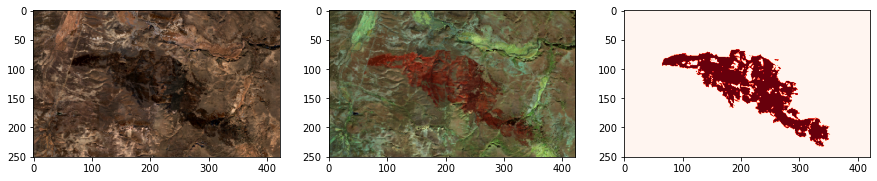

In [54]:
_, axs = plt.subplots(1, 3, figsize=(15, 6))

# plot the tile
FCI = [8, 6, 2]
TCI = [2, 1, 0]

rgb = img.data[TCI].transpose((1, 2, 0))*3#/17000
axs[0].imshow(rgb.clip(min=0, max=1))

rgb = img.data[FCI].transpose((1, 2, 0))*2#/25000
axs[1].imshow(rgb.clip(min=0, max=1))

# plot the mask
axs[2].imshow(mask.data.squeeze(), cmap='Reds')

In [55]:
from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples

# train_ds = RasterDataset(paths=(root/'images').as_posix(), crs='epsg:4326', res= 0.00025)
train_ds = RasterDataset(paths=(root/'X').as_posix(), crs='epsg:4326', res= 0.00025)

In [56]:
from torchgeo.samplers import RandomGeoSampler
sampler = RandomGeoSampler(train_ds, size= 64, length= 100)

In [57]:
import torch 

# this is to get the same result in every pass
torch.manual_seed(0)

bbox = next(iter(sampler))
sample = train_ds[bbox]
print(sample.keys())
print(sample['image'].shape)

c:\ProgramData\Anaconda3\envs\erthy\lib\site-packages\rasterio\merge.py:316: UserWarning: The nodata value, -inf, is beyond the valid range of the chosen data type, float32. Consider overriding it using the --nodata option for better results.
  warnings.warn(


dict_keys(['crs', 'bbox', 'image'])
torch.Size([11, 64, 64])


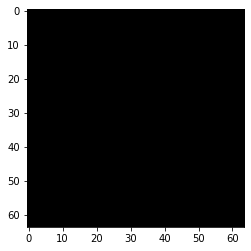

In [58]:
import torch
import matplotlib.pyplot as plt

arr = torch.clamp(sample['image'], min=0, max=1).numpy()
rgb = arr.transpose(2, 1, 0)[:, :, [8, 6, 2]]

plt.imshow(3*rgb.clip(min=0, max=1))

In [59]:
import logging
# this line is to avoid warnings from Rasterio to be printed on screen
# the warning is explained here: https://stackoverflow.com/questions/74089170/suppress-rasterio-warning-warning-1-tiffreaddirectory
logger = logging.getLogger("rasterio")
logger.setLevel(logging.ERROR)

# Creating the datasets

In [4]:
import os
import shutil
import random
from tqdm.auto import tqdm

def split_data(root, image_folder, mask_folder, train_ratio=0.8, seed=None, fromRep=None, toRep=None):
    # Create train and test directories if they don't exist
    train_dir = os.path.join(root, 'train')
    test_dir = os.path.join(root, 'test')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Create image and mask folders within train and test directories
    train_image_dir = os.path.join(train_dir, 'images')
    train_mask_dir = os.path.join(train_dir, 'masks')
    test_image_dir = os.path.join(test_dir, 'images')
    test_mask_dir = os.path.join(test_dir, 'masks')
    os.makedirs(train_image_dir, exist_ok=True)
    os.makedirs(train_mask_dir, exist_ok=True)
    os.makedirs(test_image_dir, exist_ok=True)
    os.makedirs(test_mask_dir, exist_ok=True)

    # Get list of TIFF image filenames
    image_filenames = [filename for filename in os.listdir(os.path.join(root, image_folder)) if filename.endswith('.tif')]

    # Set random seed for reproducibility
    random.seed(seed)

    # Randomly shuffle filenames
    random.shuffle(image_filenames)

    # Calculate number of samples for train and test
    num_samples = len(image_filenames)
    num_train_samples = int(num_samples * train_ratio)
    num_test_samples = num_samples - num_train_samples

    # Split images into train and test sets
    train_images = image_filenames[:num_train_samples]
    test_images = image_filenames[num_train_samples:]

    # Move images and masks to train and test directories
    for image_name in tqdm(train_images, desc='Copying train images and masks'):
        image_path = os.path.join(root, image_folder, image_name)
        mask_name = image_name.replace(fromRep, toRep)
        mask_path = os.path.join(root, mask_folder, mask_name)
        if os.path.exists(image_path) and os.path.exists(mask_path):
            shutil.copy(image_path, os.path.join(train_image_dir, image_name))
            shutil.copy(mask_path, os.path.join(train_mask_dir, mask_name))
        else:
            print(f"Either image {image_name} or mask {mask_name} does not exist.")

    for image_name in tqdm(test_images, desc='Copying test images and masks'):
        image_path = os.path.join(root, image_folder, image_name)
        mask_name = image_name.replace(fromRep, toRep)
        mask_path = os.path.join(root, mask_folder, mask_name)
        if os.path.exists(image_path) and os.path.exists(mask_path):
            shutil.copy(image_path, os.path.join(test_image_dir, image_name))
            shutil.copy(mask_path, os.path.join(test_mask_dir, mask_name))
        else:
            print(f"Either image {image_name} or mask {mask_name} does not exist.")

    print("Data split completed. Train samples:", num_train_samples, "Test samples:", num_test_samples)

# Example usage
dirname = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN"
split_data(dirname, 'X', 'Y', train_ratio=0.8, seed=42, fromRep='image_', toRep='label_')


Copying train images and masks:   0%|          | 0/740 [00:00<?, ?it/s]

Either image image_73.tif or mask label_73.tif does not exist.
Either image image_855.tif or mask label_855.tif does not exist.
Either image image_1211.tif or mask label_1211.tif does not exist.
Either image image_24.tif or mask label_24.tif does not exist.
Either image image_690.tif or mask label_690.tif does not exist.
Either image image_848.tif or mask label_848.tif does not exist.
Either image image_660.tif or mask label_660.tif does not exist.
Either image image_18.tif or mask label_18.tif does not exist.
Either image image_1399.tif or mask label_1399.tif does not exist.
Either image image_1098.tif or mask label_1098.tif does not exist.
Either image image_856.tif or mask label_856.tif does not exist.
Either image image_892.tif or mask label_892.tif does not exist.
Either image image_917.tif or mask label_917.tif does not exist.
Either image image_250.tif or mask label_250.tif does not exist.
Either image image_176.tif or mask label_176.tif does not exist.
Either image image_613.ti

Copying test images and masks:   0%|          | 0/185 [00:00<?, ?it/s]

Either image image_853.tif or mask label_853.tif does not exist.
Either image image_172.tif or mask label_172.tif does not exist.
Either image image_184.tif or mask label_184.tif does not exist.
Either image image_459.tif or mask label_459.tif does not exist.
Either image image_1111.tif or mask label_1111.tif does not exist.
Either image image_989.tif or mask label_989.tif does not exist.
Either image image_981.tif or mask label_981.tif does not exist.
Data split completed. Train samples: 740 Test samples: 185


In [5]:
# replace -inf nan values with nan
import os
import rasterio
from tqdm.auto import tqdm
import numpy as np

def process_images(directory):
    # List all files in the folder
    tif_files = [f for f in os.listdir(directory) if f.endswith('.tif')]
    for filename in tqdm(tif_files, desc="Processing images"):
        filepath = os.path.join(directory, filename)
        with rasterio.open(filepath) as src:
            # Read all bands data
            bands_data = src.read()

            # Replace -inf with NaN
            bands_data[bands_data == -np.inf] = np.nan
            
            # Update metadata
            profile = src.profile
            profile.update(nodata= np.nan)

            # Save band descriptions
            band_descriptions = [src.descriptions[i] for i in range(src.count)]
            
        # Write the data with the updated profile
        with rasterio.open(filepath, 'w', **profile) as dst:
            dst.write(bands_data)
            # Set band descriptions
            for i, desc in enumerate(band_descriptions, start=1):
                dst.set_band_description(i, desc)

        # print(f"Processed and updated {filename}.")

# Example usage
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\train\images"
process_images(directory)
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\test\images"
process_images(directory)


Processing images:   0%|          | 0/711 [00:00<?, ?it/s]

Processing images:   0%|          | 0/178 [00:00<?, ?it/s]

In [6]:
# replace -inf nan values with nan
import os
import rasterio
from tqdm.auto import tqdm
import numpy as np

def process_images(directory):
    # List all files in the folder
    tif_files = [f for f in os.listdir(directory) if f.endswith('.tif')]
    for filename in tqdm(tif_files, desc="Processing images"):
        filepath = os.path.join(directory, filename)
        with rasterio.open(filepath) as src:
            # Read all bands data
            bands_data = src.read()

            # Replace -inf with NaN
            bands_data[bands_data == -2147483648] = 0
            
            # Update metadata
            profile = src.profile
            # profile.update(nodata= np.nan)

            # Save band descriptions
            band_descriptions = [src.descriptions[i] for i in range(src.count)]
            
        # Write the data with the updated profile
        with rasterio.open(filepath, 'w', **profile) as dst:
            dst.write(bands_data)
            # Set band descriptions
            for i, desc in enumerate(band_descriptions, start=1):
                dst.set_band_description(i, desc)

        # print(f"Processed and updated {filename}.")

# Example usage
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\train\masks"
process_images(directory)
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\test\masks"
process_images(directory)


Processing images:   0%|          | 0/711 [00:00<?, ?it/s]

Processing images:   0%|          | 0/178 [00:00<?, ?it/s]

In [7]:
# replace -inf nan values with nan
import os
import rasterio
from tqdm.auto import tqdm
import numpy as np
import torch

def process_images(directory, num_classes):
    # List all files in the folder with a .tif extension
    tif_files = [f for f in os.listdir(directory) if f.endswith('.tif')]
    
    for filename in tqdm(tif_files, desc="Processing images"):
        filepath = os.path.join(directory, filename)
        
        try:
            with rasterio.open(filepath) as src:
                # Read all bands data
                bands_data = src.read()
                
                # Assuming the target tensor is one of the bands or derived from the bands
                # Example: using the first band as the target tensor (customize as needed)
                target_tensor = torch.tensor(bands_data[0], dtype=torch.long)
                
                # Check if all values in the target tensor are within valid class indices
                if not torch.all((target_tensor >= 0) & (target_tensor < num_classes)):
                    print(f"Error: {filename} contains invalid class indices.")
                    print(target_tensor)
        
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Example usage
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\train\masks"
process_images(directory, 2)
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\test\masks"
process_images(directory, 2)


Processing images:   0%|          | 0/711 [00:00<?, ?it/s]

Processing images:   0%|          | 0/178 [00:00<?, ?it/s]

In [ ]:
# remove V.* bands
import os
import rasterio
from tqdm.auto import tqdm

def process_images(directory, delete=False):
    # List all files in the folder
    tif_files = [f for f in os.listdir(directory) if f.endswith('.tif')]
    for filename in tqdm(tif_files, desc="Processing images"):
        filepath = os.path.join(directory, filename)
        with rasterio.open(filepath) as src:
            # Check for band names starting with 'V'
            band_names = src.descriptions
            bands_to_keep = [i + 1 for i, name in enumerate(band_names) if not name.startswith('V')]

            if not bands_to_keep:
                # If no bands to keep, skip or delete the image
                if delete:
                    src.close()
                    os.remove(filepath)
                    print(f"Deleted {filename} because it contains only 'V' bands.")
                else:
                    print(f"Skipped {filename} because it contains only 'V' bands.")
                continue

            if len(bands_to_keep) != len(band_names):
                # Read selected bands and metadata
                bands_data = [src.read(band) for band in bands_to_keep]
                profile = src.profile

        if bands_to_keep:
            # Update metadata
            profile.update(count=len(bands_to_keep))

            # Overwrite the image with the selected bands
            with rasterio.open(filepath, 'w', **profile) as dst:
                for idx, band_data in enumerate(bands_data, start=1):
                    dst.write(band_data, idx)
            print(f"Processed and updated {filename}.")

# Example usage
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\train\images"
process_images(directory, delete=False)
# directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\test\images"
# process_images(directory, delete=False)


# Visualise batch data

In [60]:
from pathlib import Path
from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from torchgeo.samplers import RandomGeoSampler, Units
from torch.utils.data import DataLoader

# root = Path(r"C:\Users\coach\myfiles\postdoc\Fire\data\indonesia\fire_data")
root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN')
assert root.exists()

train_imgs = RasterDataset(paths=(root/'train\images').as_posix(), crs='epsg:4326', res= 0.00025)
train_msks = RasterDataset(paths=(root/'train\masks').as_posix(), crs='epsg:4326', res= 0.00025)

# IMPORTANT
train_msks.is_image = False

In [61]:
sampler = RandomGeoSampler(train_imgs, size=256, length=30, units=Units.PIXELS)

In [62]:
# let's get a random bounding box, just to check the datasets
bbox = next(iter(sampler))

In [63]:

img_sample = train_imgs[bbox]
msk_sample = train_msks[bbox]

print(img_sample.keys(), msk_sample.keys())

dict_keys(['crs', 'bbox', 'image']) dict_keys(['crs', 'bbox', 'mask'])


In [64]:

# let's assert the patches cover the same region...
print(img_sample['bbox'])
print(msk_sample['bbox'])
assert img_sample['bbox'] == msk_sample['bbox']

BoundingBox(minx=-156.60214082431105, maxx=-156.53814082431106, miny=60.14105692416222, maxy=60.20505692416222, mint=0.0, maxt=9.223372036854776e+18)
BoundingBox(minx=-156.60214082431105, maxx=-156.53814082431106, miny=60.14105692416222, maxy=60.20505692416222, mint=0.0, maxt=9.223372036854776e+18)


In [65]:
train_dset = train_imgs & train_msks

In [66]:
sample = train_dset[bbox]
sample.keys()

dict_keys(['crs', 'bbox', 'image', 'mask'])

In [67]:
dataloader = DataLoader(train_dset, sampler=sampler, batch_size=8, collate_fn=stack_samples)
batch = next(iter(dataloader))
batch.keys()

dict_keys(['crs', 'bbox', 'image', 'mask'])

In [68]:
from typing import Iterable, List
import torch

def plot_imgs(images: Iterable, axs: Iterable, chnls: List[int] = [2, 1, 0], bright: float = 1.):
    for img, ax in zip(images, axs):
        arr = torch.clamp(bright * img, min=0, max=1).numpy()
        rgb = arr.transpose(1, 2, 0)[:, :, chnls]
        ax.imshow(rgb)
        ax.axis('off')


def plot_msks(masks: Iterable, axs: Iterable):
    for mask, ax in zip(masks, axs):
        ax.imshow(mask.squeeze().numpy(), cmap='Reds')
        ax.axis('off')

def plot_batch(batch: dict, bright: float = 3., cols: int = 4, width: int = 5, chnls: List[int] = [8, 6, 2]):

    # Get the samples and the number of items in the batch
    samples = unbind_samples(batch.copy())
    
    # if batch contains images and masks, the number of images will be doubled
    n = 2 * len(samples) if ('image' in batch) and ('mask' in batch) else len(samples)

    # calculate the number of rows in the grid
    rows = n//cols + (1 if n%cols != 0 else 0)

    # create a grid
    _, axs = plt.subplots(rows, cols, figsize=(cols*width, rows*width))  

    if ('image' in batch) and ('mask' in batch):
        # plot the images on the even axis
        plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1)[::2], chnls=chnls, bright=bright) #type: ignore

        # plot the masks on the odd axis
        plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)[1::2]) #type: ignore

    else:

        if 'image' in batch:
            plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1), chnls=chnls, bright=bright) #type: ignore
    
        elif 'mask' in batch:
            plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)) #type: ignore

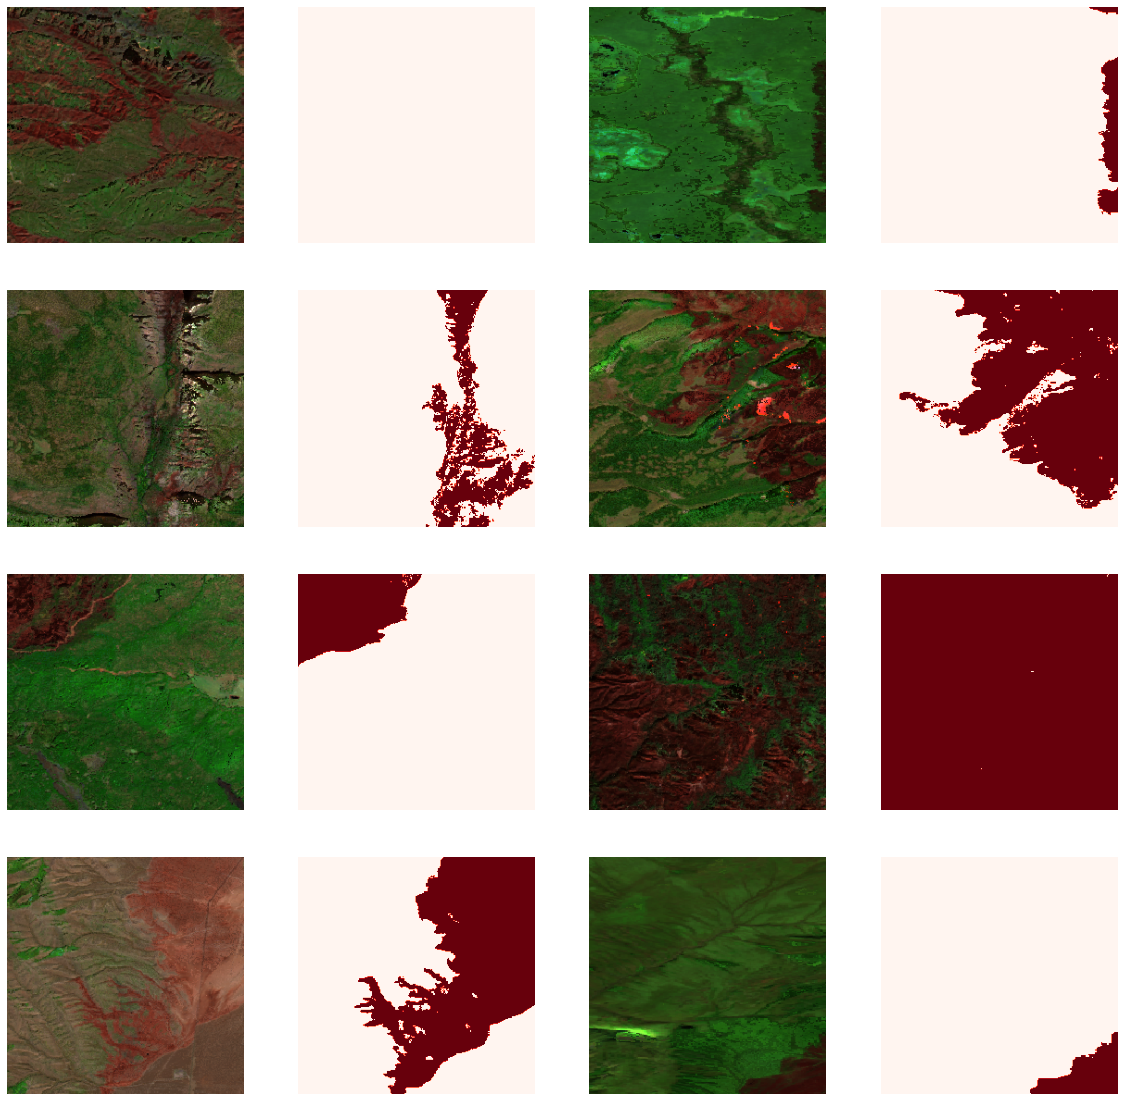

In [69]:
plot_batch(batch, 1.5)

In [71]:
from torchgeo.transforms import indices

ndwi_transform = indices.AppendNDWI(index_green=2, index_nir=4)

transformed_batch = ndwi_transform(batch['image'])
print(batch['image'].shape)
print(transformed_batch.shape)

torch.Size([8, 11, 256, 256])
torch.Size([8, 12, 256, 256])


In [72]:
import torch
from flipnslide.tiling import FlipnSlide
from typing import Any
from torch import Tensor
import kornia as K
from torchgeo.transforms import AugmentationSequential
class _FlipnSlide(K.augmentation.GeometricAugmentationBase2D):
    """Flip and slide a tensor."""

    def __init__(self, tilesize: int, viz: bool = False) -> None:
        """Initialize a new _FlipnSlide instance.

        Args:
            tilesize: desired tile size
            viz: visualization flag
        """
        super().__init__(same_on_batch = True, p=1)
        self.flags = {'tilesize': tilesize, 'viz': viz}

    def compute_transformation(
        self, input: Tensor, params: dict[str, Tensor], flags: dict[str, Any]
    ) -> Tensor:
        """Compute the transformation.

        Args:
            input: the input tensor
            params: generated parameters
            flags: static parameters

        Returns:
            the transformation
        """
        
        out: Tensor = self.identity_matrix(input)
        return out

    def apply_transform(
        self,
        input: Tensor,
        params: dict[str, Tensor],
        flags: dict[str, Any],
        transform: Tensor = None,
    ) -> Tensor:
        """Apply the transform.

        Args:
            input: the input tensor
            params: generated parameters
            flags: static parameters
            transform: the geometric transformation tensor

        Returns:
            the augmented input
        """
        np_array = input.squeeze(0).cpu().numpy()
        sample_tiled = FlipnSlide(
            tile_size=flags['tilesize'], 
            data_type='tensor',
            save=False, 
            image=np_array,
            viz=flags['viz']
        )
        return sample_tiled.tiles

# Usage with AugmentationSequential
flipnslide = _FlipnSlide(tilesize=128, viz=False)

tfms_img = AugmentationSequential(
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)
tfms_fns = AugmentationSequential(
    flipnslide,
    data_keys= ['image', 'mask']
)

dataloader = DataLoader(train_dset, sampler=sampler, batch_size=1, collate_fn=stack_samples)
batch = next(iter(dataloader))
print(batch.keys())
x = batch
print(x['image'].shape)
x = tfms_img(x)
print(x['image'].shape)

# print(tfms_both(x)['image'].shape)
x = tfms_fns(x)
print(x['mask'].unsqueeze(1).shape)

dict_keys(['crs', 'bbox', 'image', 'mask'])
torch.Size([1, 11, 256, 256])
torch.Size([1, 13, 256, 256])
torch.Size([10, 1, 128, 128])


In [73]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [74]:
import segmentation_models_pytorch as smp

model = smp.DeepLabV3Plus(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights= None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=13,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)
model = model.to(device)

In [75]:
pred = model(torch.randn(3, 13, 64, 64, device = device))
pred.shape

torch.Size([3, 2, 64, 64])

In [76]:
from typing import Dict 
def train_loop(
    epochs: int,
    train_dl: DataLoader, 
    val_dl: Optional[DataLoader], 
    model: torch.nn.Module, 
    loss_fn: Callable, 
    optimizer: torch.optim.Optimizer, 
    acc_fns: Optional[List]=None, 
    batch_tfms: Optional[Callable]=None,
    train_params: Dict=None
):
    best_chkpt_score = float("-inf")
    for epoch in tqdm(range(1, epochs+1)):
        model.train()
        optimizer.train()
        accum_loss = 0
        for batch in train_dl:

            if batch_tfms is not None:
                        # if multiple transforms, Apply transforms iteratively
                        if isinstance(batch_tfms, list):
                            batch = [tfm(batch) for tfm in batch_tfms][0]
                        else:
                            batch = batch_tfms(batch)

            X = batch['image'].to(device)
            y = batch['mask'].unsqueeze(1).type(torch.long).to(device)
            pred = model(torch.nan_to_num(X))
            loss = loss_fn(pred, y)

            # BackProp
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update the accum loss
            accum_loss += float(loss) / len(train_dl)
        
        model.eval()
        optimizer.eval()
        accum_val_loss = 0
        # Testing against the validation dataset
        if acc_fns is not None and val_dl is not None:
            # reset the accuracies metrics
            acc = [0.] * len(acc_fns)

            with torch.no_grad():
                for batch in val_dl:

                    if batch_tfms is not None:
                        # if multiple transforms, Apply transforms iteratively
                        if isinstance(batch_tfms, list):
                            batch = [tfm(batch) for tfm in batch_tfms][0]
                        else:
                            batch = batch_tfms(batch)                    

                    X = batch['image'].type(torch.float32).to(device)
                    y = batch['mask'].unsqueeze(1).type(torch.long).to(device)

                    pred = model(torch.nan_to_num(X))
                    val_loss = loss_fn(pred, y)
                    accum_val_loss += float(val_loss)/len(val_dl)

                    for i, acc_fn in enumerate(acc_fns):
                        acc[i] = float(acc[i] + acc_fn(pred, y)/len(val_dl))

            # at the end of the epoch, print the errors, etc.
            print(f'Epoch {epoch}: Train Loss={accum_loss:.5f} - Eval Accs={[round(a, 3) for a in acc]}')
        else:
            print(f'Epoch {epoch}: Train Loss={accum_loss:.5f}')

        # Check if validation loss improved
        acc_fn = acc_fns[train_params.get('metric_index')]
        chkpt_score = acc[i]
        if  chkpt_score > best_chkpt_score:
            best_chkpt_score = chkpt_score
            torch.save(model.state_dict(), train_params.get("save_model_path"))
            print(f'Saving model with validation score: {best_chkpt_score:.4f} at epoch {epoch}')

        with Live(save_dvc_exp=True) as live:
            for param_name, param_value in train_params.items():
                live.log_param(param_name, param_value)
            live.log_metric("model_saving_score", chkpt_score)
            live.log_metric("Train loss", accum_loss)
            live.log_metric("Val_loss", accum_val_loss)

In [77]:
from sklearn.metrics import jaccard_score

def oa(pred, y):
    flat_y = y.squeeze()
    flat_pred = pred.argmax(dim=1)
    acc = torch.count_nonzero(flat_y == flat_pred) / torch.numel(flat_y)
    return acc

def iou(pred, y):
    flat_y = y.cpu().numpy().squeeze()
    flat_pred = pred.argmax(dim=1).detach().cpu().numpy()
    return jaccard_score(flat_y.reshape(-1), flat_pred.reshape(-1), zero_division=1.)

def loss(p, t):    
    return torch.nn.functional.cross_entropy(p, t)

In [78]:
train_imgs = RasterDataset(paths=(root/'train\images').as_posix(), crs='epsg:4326', res= 0.00025)
train_msks = RasterDataset(paths=(root/'train\masks').as_posix(), crs='epsg:4326', res= 0.00025)

valid_imgs = RasterDataset(paths=(root/'test\images').as_posix(), crs='epsg:4326', res= 0.00025)
valid_msks = RasterDataset(paths=(root/'test\masks').as_posix(), crs='epsg:4326', res= 0.00025)

# IMPORTANT
train_msks.is_image = False
valid_msks.is_image = False

train_dset = train_imgs & train_msks
valid_dset = valid_imgs & valid_msks

# from torchgeo.samplers import RandomBatchGeoSampler
# train_sampler = RandomBatchGeoSampler(train_dset, size = 64, batch_size= 10, length=1000)
# valid_sampler = RandomBatchGeoSampler(valid_dset, size = 64, batch_size= 10, length=1000)

# train_dataloader = DataLoader(train_dset, batch_sampler=train_sampler, collate_fn=stack_samples)
# valid_dataloader = DataLoader(valid_dset, batch_sampler=valid_sampler, collate_fn=stack_samples)


train_sampler = RandomGeoSampler(train_imgs, size= 256, length = 711, units=Units.PIXELS)#667
valid_sampler = RandomGeoSampler(valid_imgs, size= 256, length = 178, units=Units.PIXELS)#287

train_dataloader = DataLoader(train_dset, sampler=train_sampler, batch_size = 1, collate_fn=stack_samples)
valid_dataloader = DataLoader(valid_dset, sampler=valid_sampler, batch_size = 1, collate_fn=stack_samples)

train_batch = next(iter(train_dataloader))
valid_batch = next(iter(valid_dataloader))
train_batch.keys(), valid_batch.keys()

(dict_keys(['crs', 'bbox', 'image', 'mask']),
 dict_keys(['crs', 'bbox', 'image', 'mask']))

In [79]:
import schedulefree
train_params = {'lr': 0.0025, #0.0001
                'weight_decay': 0.01,
                'epochs': 100,
                'metric_index': 1,
                'save_model_path': r"C:\Users\coach\myfiles\postdoc\Fire\models\DLV3P_12092024.pth"}

loss_fn = smp.losses.LovaszLoss(mode= 'multiclass')
# optimizer = torch.optim.Adam(model.parameters(), lr= train_params.get('lr'), weight_decay= train_params.get('weight_decay'))
optimizer = schedulefree.AdamWScheduleFree(model.parameters(), lr=train_params.get('lr'))
train_loop(epochs = train_params.get('epochs'), train_dl = train_dataloader, val_dl= valid_dataloader, model = model, loss_fn = loss_fn, optimizer = optimizer, 
           acc_fns=[oa, iou], batch_tfms= [tfms_img, tfms_fns], train_params = train_params)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.34835 - Eval Accs=[0.802, 0.538]
Saving model with validation score: 0.5377 at epoch 1


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 2: Train Loss=0.30971 - Eval Accs=[0.864, 0.639]
Saving model with validation score: 0.6391 at epoch 2


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 3: Train Loss=0.28268 - Eval Accs=[0.854, 0.6]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 4: Train Loss=0.27663 - Eval Accs=[0.837, 0.586]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 5: Train Loss=0.26438 - Eval Accs=[0.843, 0.611]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 6: Train Loss=0.26841 - Eval Accs=[0.863, 0.622]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 7: Train Loss=0.25148 - Eval Accs=[0.795, 0.477]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 8: Train Loss=0.26255 - Eval Accs=[0.871, 0.635]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 9: Train Loss=0.25902 - Eval Accs=[0.842, 0.619]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 10: Train Loss=0.24328 - Eval Accs=[0.84, 0.558]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 11: Train Loss=0.25490 - Eval Accs=[0.857, 0.582]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 12: Train Loss=0.25462 - Eval Accs=[0.862, 0.621]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 13: Train Loss=0.24434 - Eval Accs=[0.824, 0.581]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 14: Train Loss=0.24679 - Eval Accs=[0.842, 0.573]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 15: Train Loss=0.26826 - Eval Accs=[0.852, 0.613]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 16: Train Loss=0.25042 - Eval Accs=[0.739, 0.356]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 17: Train Loss=0.25294 - Eval Accs=[0.783, 0.481]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 18: Train Loss=0.25494 - Eval Accs=[0.842, 0.615]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 19: Train Loss=0.24754 - Eval Accs=[0.878, 0.66]
Saving model with validation score: 0.6601 at epoch 19


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 20: Train Loss=0.23348 - Eval Accs=[0.842, 0.59]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 21: Train Loss=0.23874 - Eval Accs=[0.88, 0.658]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 22: Train Loss=0.24443 - Eval Accs=[0.811, 0.495]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 23: Train Loss=0.23387 - Eval Accs=[0.807, 0.565]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 24: Train Loss=0.24975 - Eval Accs=[0.88, 0.667]
Saving model with validation score: 0.6670 at epoch 24


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 25: Train Loss=0.23207 - Eval Accs=[0.862, 0.627]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 26: Train Loss=0.24254 - Eval Accs=[0.85, 0.639]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 27: Train Loss=0.22177 - Eval Accs=[0.748, 0.46]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 28: Train Loss=0.22698 - Eval Accs=[0.861, 0.625]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 29: Train Loss=0.22441 - Eval Accs=[0.867, 0.658]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 30: Train Loss=0.22743 - Eval Accs=[0.817, 0.582]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 31: Train Loss=0.23046 - Eval Accs=[0.801, 0.528]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 32: Train Loss=0.23022 - Eval Accs=[0.781, 0.471]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 33: Train Loss=0.23357 - Eval Accs=[0.852, 0.638]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 34: Train Loss=0.23015 - Eval Accs=[0.821, 0.561]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 35: Train Loss=0.21291 - Eval Accs=[0.682, 0.272]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 36: Train Loss=0.21663 - Eval Accs=[0.833, 0.576]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 37: Train Loss=0.22265 - Eval Accs=[0.826, 0.546]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 38: Train Loss=0.21240 - Eval Accs=[0.73, 0.349]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 39: Train Loss=0.23301 - Eval Accs=[0.611, 0.128]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 40: Train Loss=0.21636 - Eval Accs=[0.854, 0.608]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 41: Train Loss=0.22242 - Eval Accs=[0.657, 0.191]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 42: Train Loss=0.24617 - Eval Accs=[0.735, 0.433]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 43: Train Loss=0.22577 - Eval Accs=[0.735, 0.357]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 44: Train Loss=0.22482 - Eval Accs=[0.787, 0.41]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 45: Train Loss=0.22120 - Eval Accs=[0.712, 0.351]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 46: Train Loss=0.22824 - Eval Accs=[0.783, 0.471]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 47: Train Loss=0.21727 - Eval Accs=[0.725, 0.307]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 48: Train Loss=0.22571 - Eval Accs=[0.71, 0.311]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 49: Train Loss=0.22169 - Eval Accs=[0.777, 0.45]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 50: Train Loss=0.21554 - Eval Accs=[0.846, 0.567]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 51: Train Loss=0.22922 - Eval Accs=[0.799, 0.517]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 52: Train Loss=0.22629 - Eval Accs=[0.652, 0.161]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 53: Train Loss=0.20390 - Eval Accs=[0.641, 0.206]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 54: Train Loss=0.21722 - Eval Accs=[0.83, 0.624]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 55: Train Loss=0.21422 - Eval Accs=[0.823, 0.568]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 56: Train Loss=0.21034 - Eval Accs=[0.819, 0.563]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 57: Train Loss=0.20826 - Eval Accs=[0.842, 0.584]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 58: Train Loss=0.22644 - Eval Accs=[0.819, 0.538]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 59: Train Loss=0.20214 - Eval Accs=[0.789, 0.466]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 60: Train Loss=0.22054 - Eval Accs=[0.859, 0.632]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 61: Train Loss=0.21584 - Eval Accs=[0.818, 0.557]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 62: Train Loss=0.23531 - Eval Accs=[0.68, 0.261]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 63: Train Loss=0.20125 - Eval Accs=[0.817, 0.563]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 64: Train Loss=0.21474 - Eval Accs=[0.79, 0.532]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 65: Train Loss=0.19521 - Eval Accs=[0.749, 0.43]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 66: Train Loss=0.20347 - Eval Accs=[0.868, 0.678]
Saving model with validation score: 0.6782 at epoch 66


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 67: Train Loss=0.20453 - Eval Accs=[0.778, 0.467]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 68: Train Loss=0.21800 - Eval Accs=[0.841, 0.642]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 69: Train Loss=0.20518 - Eval Accs=[0.869, 0.646]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 70: Train Loss=0.20352 - Eval Accs=[0.872, 0.655]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 71: Train Loss=0.21234 - Eval Accs=[0.875, 0.678]
Saving model with validation score: 0.6782 at epoch 71


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 72: Train Loss=0.22477 - Eval Accs=[0.831, 0.574]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 73: Train Loss=0.20076 - Eval Accs=[0.83, 0.555]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 74: Train Loss=0.22389 - Eval Accs=[0.794, 0.519]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 75: Train Loss=0.20629 - Eval Accs=[0.872, 0.688]
Saving model with validation score: 0.6882 at epoch 75


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 76: Train Loss=0.19882 - Eval Accs=[0.815, 0.523]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 77: Train Loss=0.21447 - Eval Accs=[0.862, 0.647]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 78: Train Loss=0.21421 - Eval Accs=[0.845, 0.535]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 79: Train Loss=0.20994 - Eval Accs=[0.837, 0.553]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 80: Train Loss=0.20217 - Eval Accs=[0.714, 0.321]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 81: Train Loss=0.20344 - Eval Accs=[0.841, 0.623]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 82: Train Loss=0.20301 - Eval Accs=[0.849, 0.612]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 83: Train Loss=0.19927 - Eval Accs=[0.86, 0.613]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 84: Train Loss=0.19659 - Eval Accs=[0.71, 0.336]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 85: Train Loss=0.19332 - Eval Accs=[0.855, 0.648]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 86: Train Loss=0.20271 - Eval Accs=[0.841, 0.605]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 87: Train Loss=0.19730 - Eval Accs=[0.738, 0.349]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 88: Train Loss=0.19535 - Eval Accs=[0.815, 0.513]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 89: Train Loss=0.19957 - Eval Accs=[0.714, 0.3]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 90: Train Loss=0.20206 - Eval Accs=[0.798, 0.456]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 91: Train Loss=0.18589 - Eval Accs=[0.707, 0.315]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 92: Train Loss=0.19169 - Eval Accs=[0.823, 0.523]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 93: Train Loss=0.19266 - Eval Accs=[0.747, 0.246]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 94: Train Loss=0.20246 - Eval Accs=[0.86, 0.63]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 95: Train Loss=0.20011 - Eval Accs=[0.78, 0.415]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 96: Train Loss=0.18684 - Eval Accs=[0.811, 0.522]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 97: Train Loss=0.18261 - Eval Accs=[0.685, 0.27]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 98: Train Loss=0.21456 - Eval Accs=[0.776, 0.423]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 99: Train Loss=0.19227 - Eval Accs=[0.86, 0.623]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 100: Train Loss=0.20699 - Eval Accs=[0.719, 0.282]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


# Plot predictions

In [80]:
import torch
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from pathlib import Path
from torchgeo.samplers import RandomGeoSampler, Units
from torchgeo.transforms import indices
from torchgeo.transforms import AugmentationSequential
import numpy as np
import matplotlib.pyplot as plt


In [82]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = smp.DeepLabV3Plus(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
# checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\UNet_16082024.pth")
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\DLV3P_12092024.pth")

model.load_state_dict(checkpoint)
model.eval()

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [83]:
root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN')
assert root.exists()
valid_imgs = RasterDataset(paths=(root/'test\images').as_posix(), crs='epsg:4326', res= 0.00025)
valid_msks = RasterDataset(paths=(root/'test\masks').as_posix(), crs='epsg:4326', res= 0.00025)
valid_dset = valid_imgs & valid_msks

# IMPORTANT
valid_msks.is_image = False
valid_sampler = RandomGeoSampler(valid_imgs, size= 256, length = 178, units=Units.PIXELS)#287

tfms_img = AugmentationSequential(
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)

valid_dataloader = DataLoader(valid_dset, sampler=valid_sampler, batch_size = 8, collate_fn=stack_samples)
batch = next(iter(valid_dataloader))
inB = tfms_img(batch)['image'].to(device)
out = model(inB)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


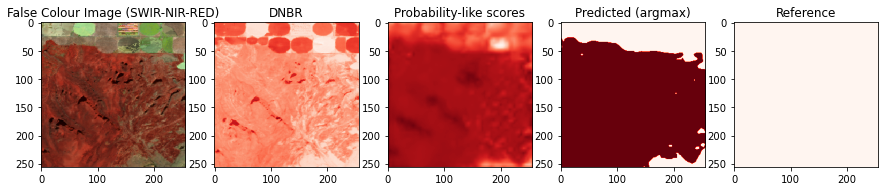

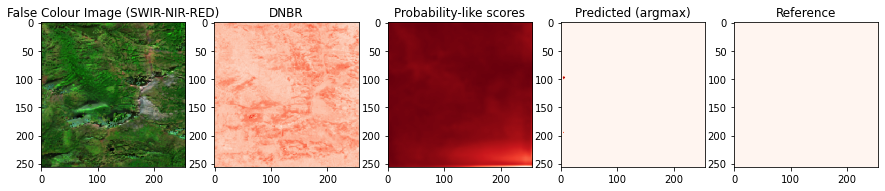

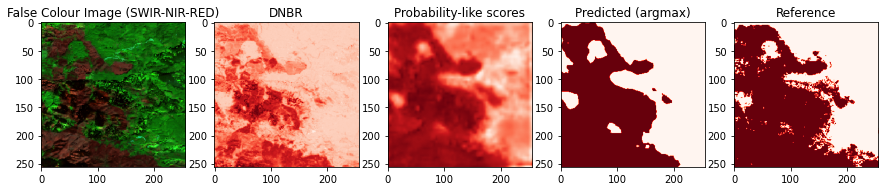

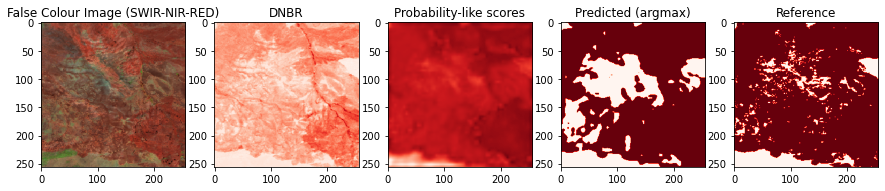

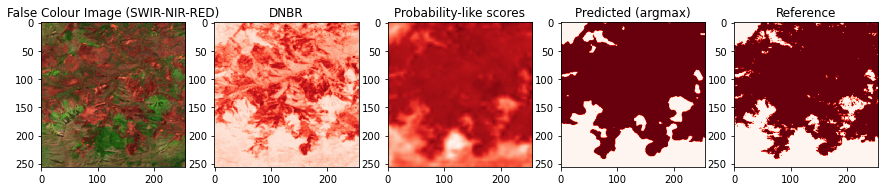

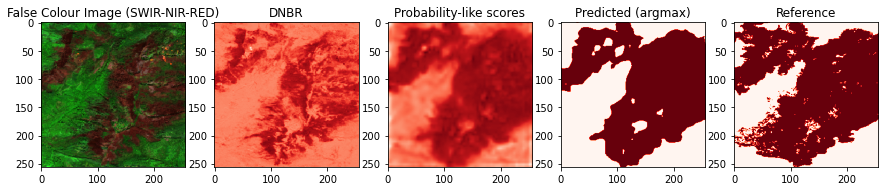

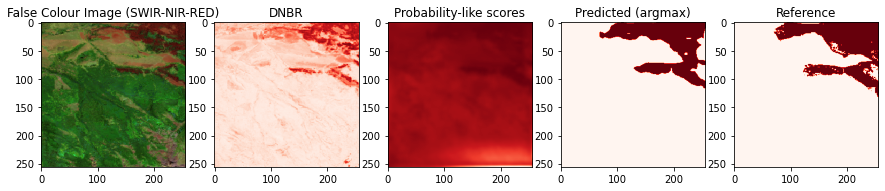

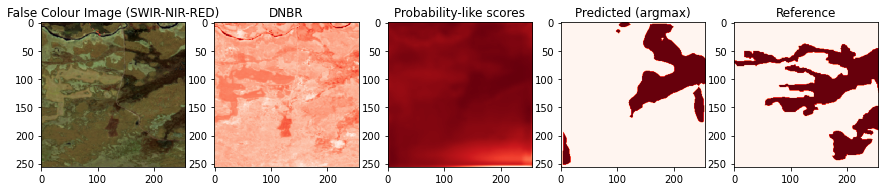

In [84]:
def plot_batch_preds(batch):
    for idx in range(0, 8):
        _, axs = plt.subplots(1, 5, figsize=(15, 6))

        # Define the labels
        labels = ['False Colour Image (SWIR-NIR-RED)', 'DNBR', 'Probability-like scores','Predicted (argmax)',  'Reference']

        inBatch = batch['image']
        img = inBatch[idx,[8, 6, 2],:,:].cpu().numpy()*2
        mask = batch['mask'][idx].cpu().numpy()
        
        rgb = img.transpose((1, 2, 0))
        axs[0].imshow(rgb)
        # plot the tile
        axs[0].set_title(labels[0])

        dnbr = inBatch[idx,10,:,:].cpu().numpy()*2
        axs[1].imshow(dnbr, cmap = 'Reds')
        # plot the tile
        axs[1].set_title(labels[1])

        # plot the predicted mask
        axs[2].imshow(out[idx,1,:,:].detach().cpu().numpy().squeeze(), cmap='Reds')
        axs[2].set_title(labels[2])

        pred_mask = np.argmax(out[idx].detach().cpu().numpy(), axis=0)
        axs[3].imshow(pred_mask, cmap='Reds')
        axs[3].set_title(labels[3])

        # plot the reference mask
        axs[4].imshow(mask.squeeze(), cmap='Reds')
        axs[4].set_title(labels[4])

plot_batch_preds(batch)


# SA Data

In [1]:
# replace -inf nan values with nan
import os
import rasterio
from tqdm.auto import tqdm
import numpy as np

def process_images(directory):
    # List all files in the folder
    tif_files = [f for f in os.listdir(directory) if f.endswith('.tif')]
    for filename in tqdm(tif_files, desc="Processing images"):
        filepath = os.path.join(directory, filename)
        with rasterio.open(filepath) as src:
            # Read all bands data
            bands_data = src.read()

            # Replace -inf with NaN
            bands_data[bands_data == -np.inf] = np.nan
            
            # Update metadata
            profile = src.profile
            profile.update(nodata= np.nan)

            # Save band descriptions
            band_descriptions = [src.descriptions[i] for i in range(src.count)]
            
        # Write the data with the updated profile
        with rasterio.open(filepath, 'w', **profile) as dst:
            dst.write(bands_data)
            # Set band descriptions
            for i, desc in enumerate(band_descriptions, start=1):
                dst.set_band_description(i, desc)

        # print(f"Processed and updated {filename}.")

# Example usage
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\X_test"
process_images(directory)


Processing images:   0%|          | 0/10 [00:00<?, ?it/s]

In [2]:
import torch
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from pathlib import Path
from torchgeo.samplers import RandomGeoSampler, Units
from torchgeo.transforms import indices
from torchgeo.transforms import AugmentationSequential
import numpy as np
import matplotlib.pyplot as plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

modelunet = smp.Unet(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)

checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\UNet_16082024.pth")

modelunet.load_state_dict(checkpoint)
modelunet.eval()

model = smp.DeepLabV3Plus(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\DLV3P_12092024.pth")

model.load_state_dict(checkpoint)
model.eval()

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [7]:
root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN')
assert root.exists()
test_imgs = RasterDataset(paths=(root/'X_test').as_posix(), crs='epsg:4326', res= 0.00025)

# IMPORTANT
test_sampler = RandomGeoSampler(test_imgs, size= 128, length = 178, units=Units.PIXELS)#287

tfms_img = AugmentationSequential(
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)

test_dataloader = DataLoader(test_imgs, sampler= test_sampler, batch_size = 8, collate_fn=stack_samples)
batch = next(iter(test_dataloader))
inB = tfms_img(batch)['image'].to(device)
out = model(inB)
outunet = modelunet(inB)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


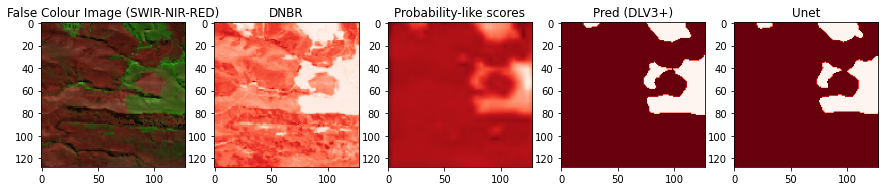

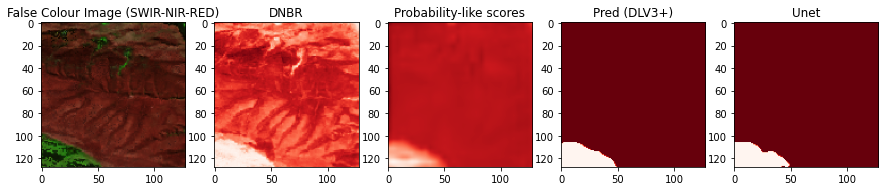

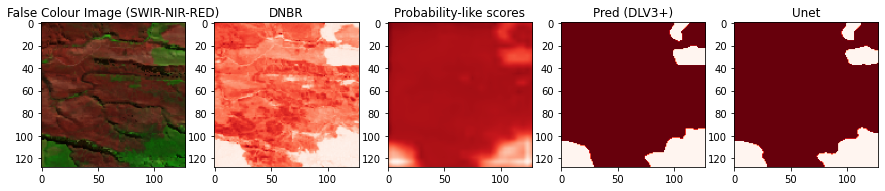

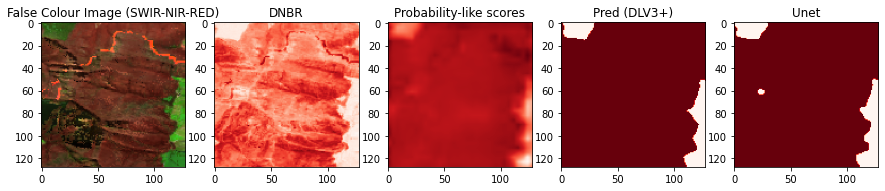

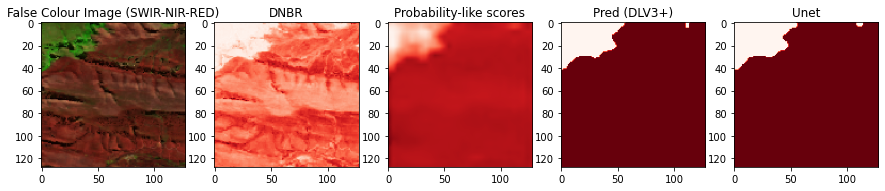

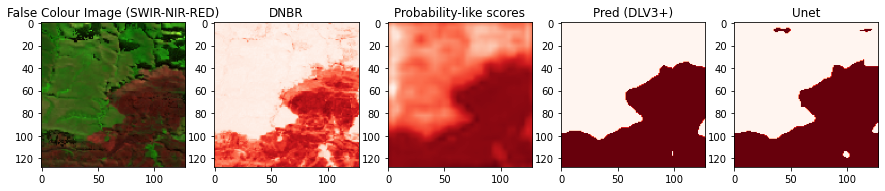

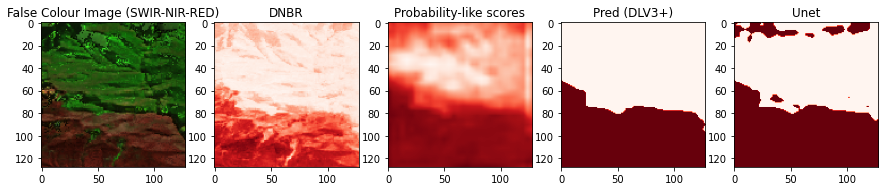

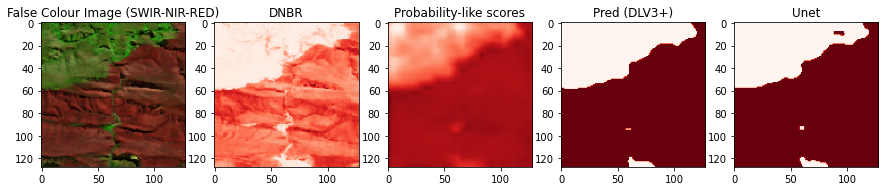

In [8]:
def plot_batch_preds(batch):
    for idx in range(0, 8):
        _, axs = plt.subplots(1, 5, figsize=(15, 6))

        # Define the labels
        labels = ['False Colour Image (SWIR-NIR-RED)', 'DNBR', 'Probability-like scores','Pred (DLV3+)',  'Unet']

        inBatch = batch['image']
        img = inBatch[idx,[8, 6, 2],:,:].cpu().numpy()*2
                
        rgb = img.transpose((1, 2, 0))
        axs[0].imshow(rgb)
        # plot the tile
        axs[0].set_title(labels[0])

        dnbr = inBatch[idx,10,:,:].cpu().numpy()*2
        axs[1].imshow(dnbr, cmap = 'Reds')
        # plot the tile
        axs[1].set_title(labels[1])

        # plot the predicted mask
        axs[2].imshow(out[idx,1,:,:].detach().cpu().numpy().squeeze(), cmap='Reds')
        axs[2].set_title(labels[2])

        pred_mask = np.argmax(out[idx].detach().cpu().numpy(), axis=0)
        axs[3].imshow(pred_mask, cmap='Reds')
        axs[3].set_title(labels[3])

        pred_mask = np.argmax(outunet[idx].detach().cpu().numpy(), axis=0)
        axs[4].imshow(pred_mask, cmap='Reds')
        axs[4].set_title(labels[4])

plot_batch_preds(batch)

# Finetuning

In [6]:
# Prepare data
import os
import shutil
import rasterio
from tqdm.auto import tqdm
import random

def copy_projection_and_sort(
    masks_folder: str, 
    images_folder: str, 
    train_folder: str, 
    test_folder: str, 
    test_ratio: float = 0.2
) -> None:
    """
    Copies projection information from images in `images_folder` to matching masks in `masks_folder` 
    based on matching names after the first underscore. Then, copies both masks and images to 
    train or test folders.

    Args:
        masks_folder (str): Path to the folder containing mask TIFF files.
        images_folder (str): Path to the folder containing image TIFF files.
        train_folder (str): Path to the folder where train images and masks will be stored.
        test_folder (str): Path to the folder where test images and masks will be stored.
        test_ratio (float, optional): Proportion of files to copy to the test folder. Defaults to 0.2.
    """
    # Ensure train and test folders exist for both X (images) and Y (masks)
    os.makedirs(os.path.join(train_folder, 'X'), exist_ok=True)
    os.makedirs(os.path.join(test_folder, 'X'), exist_ok=True)
    os.makedirs(os.path.join(train_folder, 'Y'), exist_ok=True)
    os.makedirs(os.path.join(test_folder, 'Y'), exist_ok=True)

    # List all mask files in the masks folder
    mask_files = [f for f in os.listdir(masks_folder) if f.endswith('.tif')]
    
    # Randomize the order of files to ensure better train-test split
    random.shuffle(mask_files)
    
    for mask_file in tqdm(mask_files, desc="Processing masks"):
        # Get the part of the mask filename after the first underscore
        mask_id = mask_file.split('_', 1)[1]

        # Try to find the corresponding image in the images folder
        matching_images = [f for f in os.listdir(images_folder) if mask_id in f]
        if not matching_images:
            print(f"No matching image found for {mask_file}. Skipping...")
            continue

        image_file = matching_images[0]  # Assuming the first match is the correct one

        # Read the projection information from the image file
        image_path = os.path.join(images_folder, image_file)
        mask_path = os.path.join(masks_folder, mask_file)

        with rasterio.open(image_path) as src_image:
            image_crs = src_image.crs
            image_transform = src_image.transform

        # Copy the mask file with updated projection information
        with rasterio.open(mask_path, 'r+') as dst_mask:
            dst_mask.crs = image_crs
            dst_mask.transform = image_transform

        # Determine if the file goes into train or test set based on test_ratio
        if random.random() < test_ratio:
            dest_folder = test_folder
        else:
            dest_folder = train_folder

        # Copy both the mask and the corresponding image to the destination folder
        shutil.copy(mask_path, os.path.join(dest_folder, 'Y', mask_file))
        shutil.copy(image_path, os.path.join(dest_folder, 'X', image_file))


# Example usage:
maskPath = r"C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\irisLabels"
maskPath = r"C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\altY_chips"
imagePath = r"C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\X_chips"
trainFolder = r"C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2\train"
testFolder = r"C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2\test"
copy_projection_and_sort(maskPath, imagePath, trainFolder, testFolder, 0.15)


Processing masks:   0%|          | 0/370 [00:00<?, ?it/s]

In [9]:
import torch
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from pathlib import Path
from typing import Iterable, List, Optional, Callable

from torchgeo.samplers import RandomGeoSampler, Units
from torchgeo.transforms import indices
from torchgeo.transforms import AugmentationSequential
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
from flipnslide.tiling import FlipnSlide
from typing import Any
from torch import Tensor
import kornia as K
from torchgeo.transforms import AugmentationSequential
class _FlipnSlide(K.augmentation.GeometricAugmentationBase2D):
    """Flip and slide a tensor."""

    def __init__(self, tilesize: int, viz: bool = False) -> None:
        """Initialize a new _FlipnSlide instance.

        Args:
            tilesize: desired tile size
            viz: visualization flag
        """
        super().__init__(same_on_batch = True, p=1)
        self.flags = {'tilesize': tilesize, 'viz': viz}

    def compute_transformation(
        self, input: Tensor, params: dict[str, Tensor], flags: dict[str, Any]
    ) -> Tensor:
        """Compute the transformation.

        Args:
            input: the input tensor
            params: generated parameters
            flags: static parameters

        Returns:
            the transformation
        """
        
        out: Tensor = self.identity_matrix(input)
        return out

    def apply_transform(
        self,
        input: Tensor,
        params: dict[str, Tensor],
        flags: dict[str, Any],
        transform: Tensor = None,
    ) -> Tensor:
        """Apply the transform.

        Args:
            input: the input tensor
            params: generated parameters
            flags: static parameters
            transform: the geometric transformation tensor

        Returns:
            the augmented input
        """
        np_array = input.squeeze(0).cpu().numpy()
        sample_tiled = FlipnSlide(
            tile_size=flags['tilesize'], 
            data_type='tensor',
            save=False, 
            image=np_array,
            viz=flags['viz']
        )
        return sample_tiled.tiles

# Usage with AugmentationSequential
flipnslide = _FlipnSlide(tilesize=128, viz=False)

tfms_img = AugmentationSequential(
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)
tfms_fns = AugmentationSequential(
    flipnslide,
    data_keys= ['image', 'mask']
)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
modelunet = smp.Unet(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\UNet_16082024.pth")
modelunet.load_state_dict(checkpoint)

model = smp.DeepLabV3Plus(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\DLV3P_12092024.pth")
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [4]:
from typing import Dict 
def train_loop(
    epochs: int,
    train_dl: DataLoader, 
    val_dl: Optional[DataLoader], 
    model: torch.nn.Module, 
    loss_fn: Callable, 
    optimizer: torch.optim.Optimizer, 
    acc_fns: Optional[List]=None, 
    batch_tfms: Optional[Callable]=None,
    train_params: Dict=None
):
    best_chkpt_score = float("-inf")
    for epoch in tqdm(range(1, epochs+1)):
        model.train()
        optimizer.train()
        accum_loss = 0
        for batch in train_dl:

            if batch_tfms is not None:
                        # if multiple transforms, Apply transforms iteratively
                        if isinstance(batch_tfms, list):
                            batch = [tfm(batch) for tfm in batch_tfms][0]
                        else:
                            batch = batch_tfms(batch)

            X = batch['image'].to(device)
            y = batch['mask'].unsqueeze(1).type(torch.long).to(device)
            pred = model(torch.nan_to_num(X))
            loss = loss_fn(pred, y)

            # BackProp
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update the accum loss
            accum_loss += float(loss) / len(train_dl)
        
        model.eval()
        optimizer.eval()
        accum_val_loss = 0
        # Testing against the validation dataset
        if acc_fns is not None and val_dl is not None:
            # reset the accuracies metrics
            acc = [0.] * len(acc_fns)

            with torch.no_grad():
                for batch in val_dl:

                    if batch_tfms is not None:
                        # if multiple transforms, Apply transforms iteratively
                        if isinstance(batch_tfms, list):
                            batch = [tfm(batch) for tfm in batch_tfms][0]
                        else:
                            batch = batch_tfms(batch)                    

                    X = batch['image'].type(torch.float32).to(device)
                    y = batch['mask'].unsqueeze(1).type(torch.long).to(device)

                    pred = model(torch.nan_to_num(X))
                    val_loss = loss_fn(pred, y)
                    accum_val_loss += float(val_loss)/len(val_dl)

                    for i, acc_fn in enumerate(acc_fns):
                        acc[i] = float(acc[i] + acc_fn(pred, y)/len(val_dl))

            # at the end of the epoch, print the errors, etc.
            print(f'Epoch {epoch}: Train Loss={accum_loss:.5f} - Eval Accs={[round(a, 3) for a in acc]}')
        else:
            print(f'Epoch {epoch}: Train Loss={accum_loss:.5f}')

        # Check if validation loss improved
        acc_fn = acc_fns[train_params.get('metric_index')]
        chkpt_score = acc[i]
        if  chkpt_score > best_chkpt_score:
            best_chkpt_score = chkpt_score
            torch.save(model.state_dict(), train_params.get("save_model_path"))
            print(f'Saving model with validation score: {best_chkpt_score:.4f} at epoch {epoch}')

        with Live(save_dvc_exp=True) as live:
            for param_name, param_value in train_params.items():
                live.log_param(param_name, param_value)
            live.log_metric("model_saving_score", chkpt_score)
            live.log_metric("Train loss", accum_loss)
            live.log_metric("Val_loss", accum_val_loss)

In [5]:
from sklearn.metrics import jaccard_score

def oa(pred, y):
    flat_y = y.squeeze()
    flat_pred = pred.argmax(dim=1)
    acc = torch.count_nonzero(flat_y == flat_pred) / torch.numel(flat_y)
    return acc

def iou(pred, y):
    flat_y = y.cpu().numpy().squeeze()
    flat_pred = pred.argmax(dim=1).detach().cpu().numpy()
    return jaccard_score(flat_y.reshape(-1), flat_pred.reshape(-1), zero_division=1.)

def loss(p, t):    
    return torch.nn.functional.cross_entropy(p, t)

In [7]:
root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2')
assert root.exists()
train_imgs = RasterDataset(paths=(root/'train\X').as_posix(), crs='epsg:4326', res= 0.00025)
train_msks = RasterDataset(paths=(root/'train\Y').as_posix(), crs='epsg:4326', res= 0.00025)

valid_imgs = RasterDataset(paths=(root/'test\X').as_posix(), crs='epsg:4326', res= 0.00025)
valid_msks = RasterDataset(paths=(root/'test\Y').as_posix(), crs='epsg:4326', res= 0.00025)

# IMPORTANT
train_msks.is_image = False
valid_msks.is_image = False

train_dset = train_imgs & train_msks
valid_dset = valid_imgs & valid_msks

train_sampler = RandomGeoSampler(train_imgs, size= 256, length = 320, units=Units.PIXELS)#667
valid_sampler = RandomGeoSampler(valid_imgs, size= 256, length = 50, units=Units.PIXELS)#287

train_dataloader = DataLoader(train_dset, sampler=train_sampler, batch_size = 1, collate_fn=stack_samples)
valid_dataloader = DataLoader(valid_dset, sampler=valid_sampler, batch_size = 1, collate_fn=stack_samples)

train_batch = next(iter(train_dataloader))
valid_batch = next(iter(valid_dataloader))
train_batch.keys(), valid_batch.keys()

(dict_keys(['crs', 'bbox', 'image', 'mask']),
 dict_keys(['crs', 'bbox', 'image', 'mask']))

In [8]:
import schedulefree
train_params = {'lr': 0.0025, #0.0001
                'weight_decay': 0.01,
                'epochs': 100,
                'metric_index': 1,
                'save_model_path': r"C:\Users\coach\myfiles\postdoc\Fire\models\FT2DLV3P_16092024.pth"}

loss_fn = smp.losses.LovaszLoss(mode= 'multiclass')
# optimizer = torch.optim.Adam(model.parameters(), lr= train_params.get('lr'), weight_decay= train_params.get('weight_decay'))
optimizer = schedulefree.AdamWScheduleFree(model.parameters(), lr=train_params.get('lr'))
train_loop(epochs = train_params.get('epochs'), train_dl = train_dataloader, val_dl= valid_dataloader, model = model, loss_fn = loss_fn, optimizer = optimizer, 
           acc_fns=[oa, iou], batch_tfms= [tfms_img, tfms_fns], train_params = train_params)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.36347 - Eval Accs=[0.832, 0.314]
Saving model with validation score: 0.3141 at epoch 1


NameError: name 'Live' is not defined

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = smp.Unet(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\FTUNet_12092024.pth")
model.load_state_dict(checkpoint)
model.eval()

modelus = smp.Unet(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\UNet_16082024.pth")
modelus.load_state_dict(checkpoint)
modelus.eval()

modeldlft = smp.DeepLabV3Plus(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\FTDLV3P_12092024.pth")
modeldlft.load_state_dict(checkpoint)
modeldlft.eval()

modeldlus = smp.DeepLabV3Plus(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\DLV3P_12092024.pth")
modeldlus.load_state_dict(checkpoint)
modeldlus.eval()

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [3]:
root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft')
assert root.exists()
# valid_imgs = RasterDataset(paths=(root/'test\X').as_posix(), crs='epsg:4326', res= 0.00025)
# valid_msks = RasterDataset(paths=(root/'test\Y').as_posix(), crs='epsg:4326', res= 0.00025)

valid_imgs = RasterDataset(paths=(root/'train\X').as_posix(), crs='epsg:4326', res= 0.00025)
valid_msks = RasterDataset(paths=(root/'train\Y').as_posix(), crs='epsg:4326', res= 0.00025)
valid_dset = valid_imgs & valid_msks

# IMPORTANT
valid_msks.is_image = False
valid_sampler = RandomGeoSampler(valid_imgs, size= 256, length = 78, units=Units.PIXELS)#287

tfms_img = AugmentationSequential(
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)

In [4]:
valid_dataloader = DataLoader(valid_dset, sampler=valid_sampler, batch_size = 8, collate_fn=stack_samples)
batch = next(iter(valid_dataloader))
inB = tfms_img(batch)['image'].to(device)
out = model(inB)
outus = modelus(inB)
outdlft = modeldlft(inB)
outdlus = modeldlus(inB)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


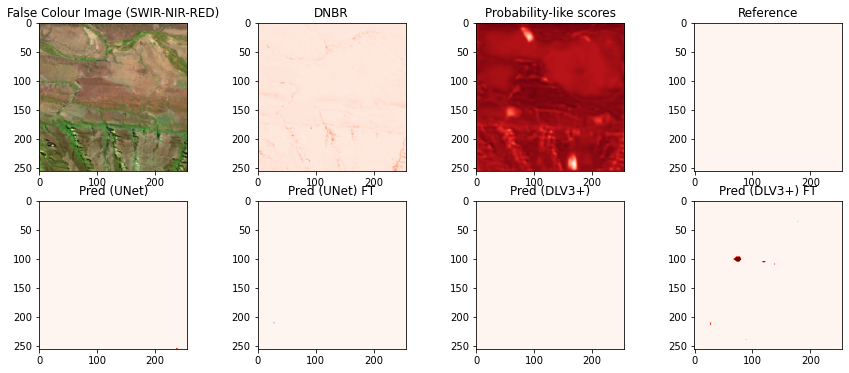

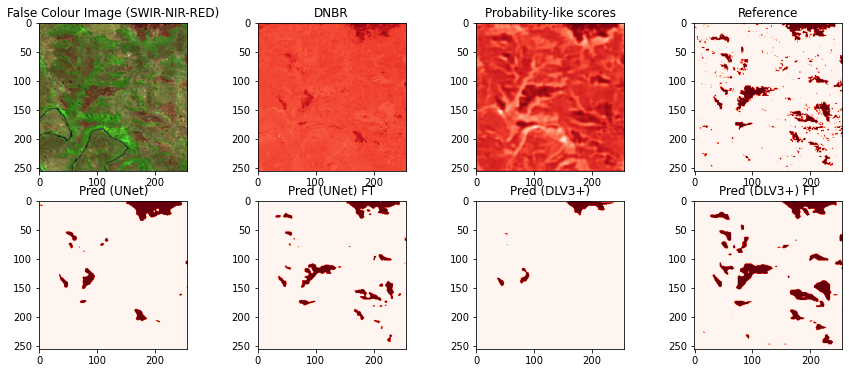

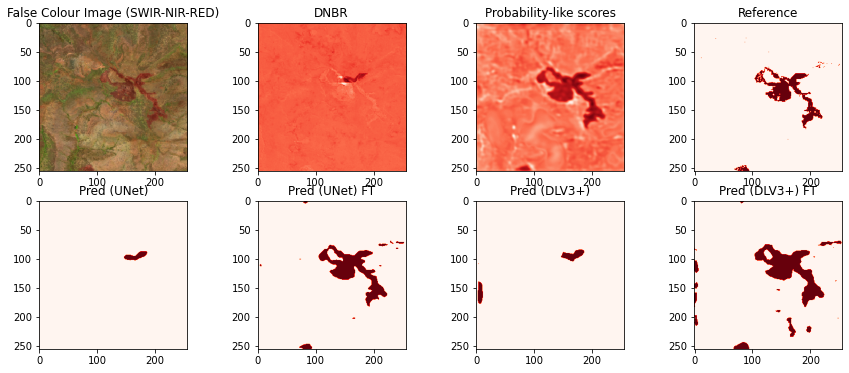

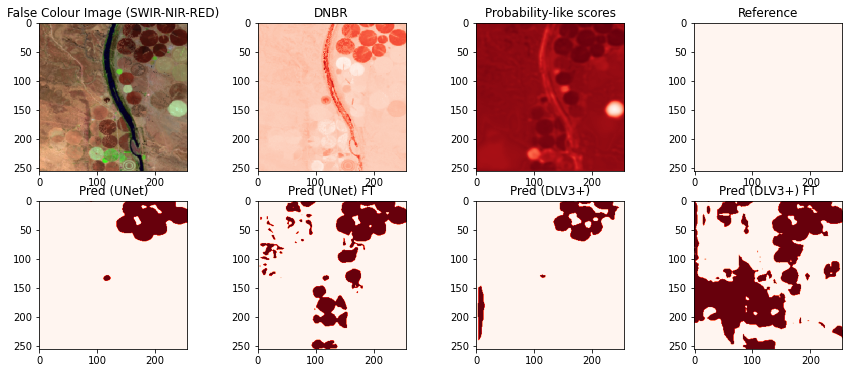

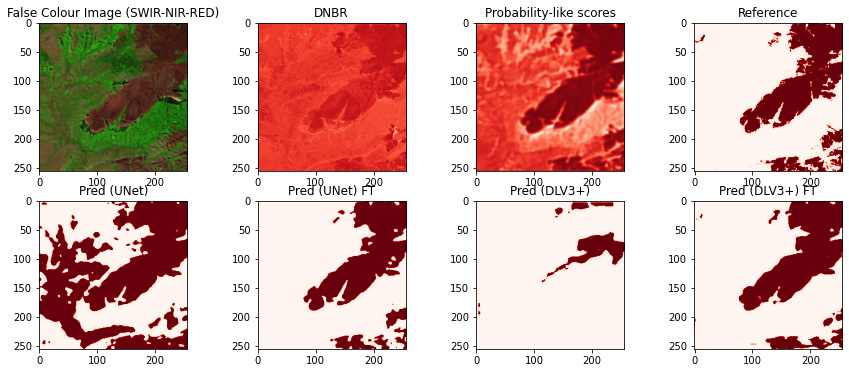

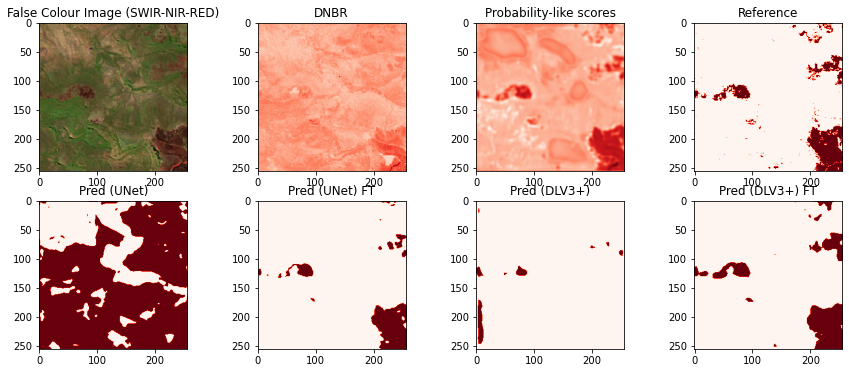

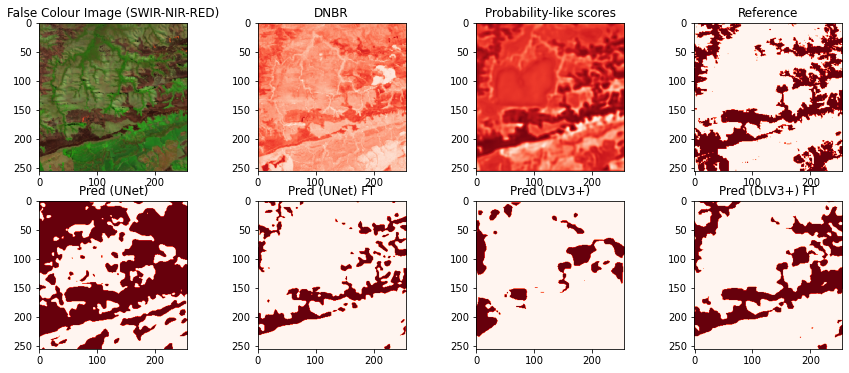

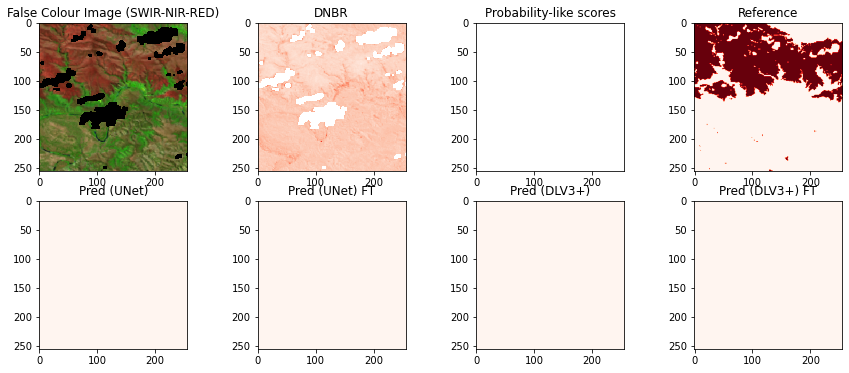

In [148]:
def plot_batch_preds(batch):
    for idx in range(0, 8):
        _, axs = plt.subplots(2, 4, figsize=(15, 6))

        # Define the labels
        labels = ['False Colour Image (SWIR-NIR-RED)', 'DNBR', 'Probability-like scores','Pred (UNet)', 'Pred (UNet) FT','Pred (DLV3+)', 'Pred (DLV3+) FT',  'Reference']

        inBatch = batch['image']
        img = inBatch[idx,[8, 6, 2],:,:].cpu().numpy()*2
        mask = batch['mask'][idx].cpu().numpy()
        
        rgb = img.transpose((1, 2, 0))
        axs[0, 0].imshow(rgb)
        # plot the tile
        axs[0, 0].set_title(labels[0])

        dnbr = inBatch[idx,10,:,:].cpu().numpy()*2
        axs[0, 1].imshow(dnbr, cmap = 'Reds')
        # plot the tile
        axs[0, 1].set_title(labels[1])

        # plot the predicted mask
        axs[0, 2].imshow(out[idx,1,:,:].detach().cpu().numpy().squeeze(), cmap='Reds')
        axs[0, 2].set_title(labels[2])

        pred_mask = np.argmax(outus[idx].detach().cpu().numpy(), axis=0)
        axs[1,0].imshow(pred_mask, cmap='Reds')
        axs[1,0].set_title(labels[3])

        pred_mask = np.argmax(out[idx].detach().cpu().numpy(), axis=0)
        axs[1,1].imshow(pred_mask, cmap='Reds')
        axs[1,1].set_title(labels[4])

        pred_mask = np.argmax(outdlus[idx].detach().cpu().numpy(), axis=0)
        axs[1,2].imshow(pred_mask, cmap='Reds')
        axs[1,2].set_title(labels[5])

        pred_mask = np.argmax(outdlft[idx].detach().cpu().numpy(), axis=0)
        axs[1,3].imshow(pred_mask, cmap='Reds')
        axs[1,3].set_title(labels[6])

        # plot the reference mask
        axs[0,3].imshow(mask.squeeze(), cmap='Reds')
        axs[0,3].set_title(labels[7])

plot_batch_preds(batch)


In [13]:
root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN')
assert root.exists()
test_imgs = RasterDataset(paths=(root/'X_test').as_posix(), crs='epsg:4326', res= 0.00025)
test_masks = RasterDataset(paths=(root/'Y_test').as_posix(), crs='epsg:4326', res= 0.00025)
# IMPORTANT
test_masks.is_image = False
test_dset = test_imgs & test_masks

# IMPORTANT
test_sampler = RandomGeoSampler(test_dset, size= 224, length = 10, units=Units.PIXELS)

tfms_img = AugmentationSequential(
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)

test_dataloader = DataLoader(test_dset, sampler= test_sampler, batch_size = 8, collate_fn=stack_samples)
batch = next(iter(test_dataloader))
inB = tfms_img(batch)['image'].to(device)
out = model(inB)
outus = modelus(inB)
outdlft = modeldlft(inB)
outdlus = modeldlus(inB)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


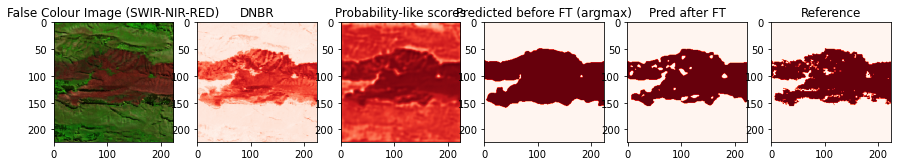

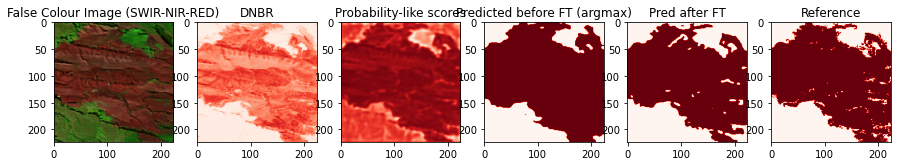

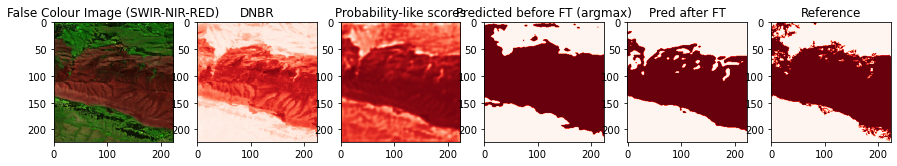

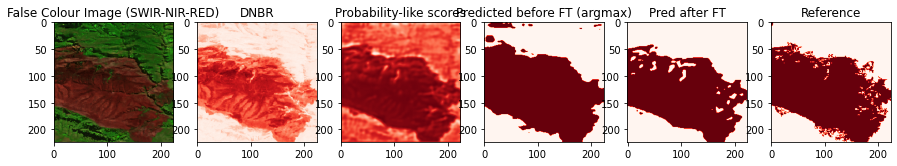

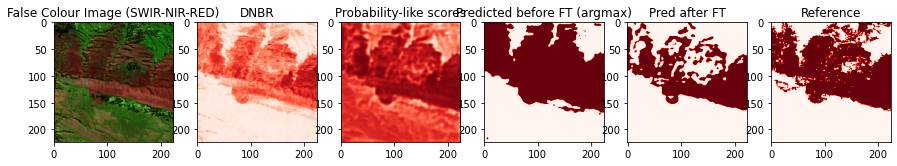

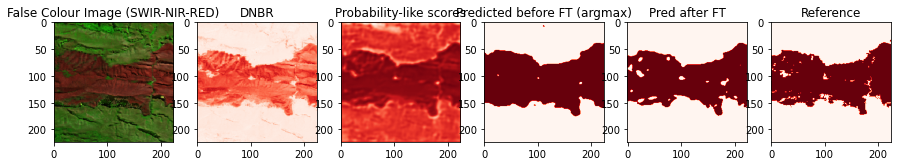

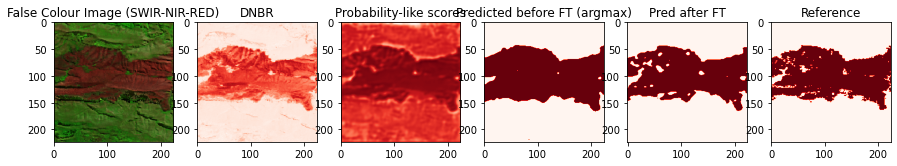

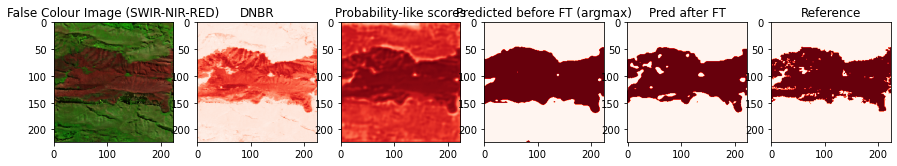

In [15]:
def plot_batch_preds(batch):
    for idx in range(0, 8):
        _, axs = plt.subplots(1, 6, figsize=(15, 6))

        # Define the labels
        labels = ['False Colour Image (SWIR-NIR-RED)', 'DNBR', 'Probability-like scores','Predicted before FT (argmax)',  'Pred after FT', 'Reference']

        inBatch = batch['image']
        img = inBatch[idx,[8, 6, 2],:,:].cpu().numpy()*2
                
        rgb = img.transpose((1, 2, 0))
        axs[0].imshow(rgb)
        # plot the tile
        axs[0].set_title(labels[0])

        dnbr = inBatch[idx,10,:,:].cpu().numpy()*2
        axs[1].imshow(dnbr, cmap = 'Reds')
        # plot the tile
        axs[1].set_title(labels[1])

        # plot the predicted mask
        axs[2].imshow(out[idx,1,:,:].detach().cpu().numpy().squeeze(), cmap='Reds')
        axs[2].set_title(labels[2])

        pred_mask = np.argmax(outus[idx].detach().cpu().numpy(), axis=0)
        axs[3].imshow(pred_mask, cmap='Reds')
        axs[3].set_title(labels[3])

        pred_mask = np.argmax(out[idx].detach().cpu().numpy(), axis=0)
        axs[4].imshow(pred_mask, cmap='Reds')
        axs[4].set_title(labels[4])

        mask = batch['mask'][idx].cpu().numpy()
        # plot the reference mask
        axs[5].imshow(mask.squeeze(), cmap='Reds')
        axs[5].set_title(labels[5])

plot_batch_preds(batch)

In [17]:
from torchcp.classification.scores import THR, SAPS
from torchcp.classification.predictors import SplitPredictor

# Preparing a calibration data and a test data.
# cal_dataloader = ...
root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN')
assert root.exists()
test_imgs = RasterDataset(paths=(root/'X_test').as_posix(), crs='epsg:4326', res= 0.00025)
test_masks = RasterDataset(paths=(root/'Y_test').as_posix(), crs='epsg:4326', res= 0.00025)
# IMPORTANT
test_masks.is_image = False
test_dset = test_imgs & test_masks

# IMPORTANT
test_sampler = RandomGeoSampler(test_dset, size= 224, length = 10, units=Units.PIXELS)

tfms_img = AugmentationSequential(
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)

test_dataloader = DataLoader(test_dset, sampler= test_sampler, batch_size = 8, collate_fn=stack_samples)

# Preparing a pytorch model
modeldlft = smp.DeepLabV3Plus(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\FTDLV3P_12092024.pth")
modeldlft.load_state_dict(checkpoint)
modeldlft.eval()

# Options of score function: THR, APS, SAPS, RAPS
# Define a conformal prediction algorithm. Optional: SplitPredictor, ClusteredPredictor, ClassWisePredictor
predictor = SplitPredictor(score_function=THR(), model=modeldlft)

# Calibrating the predictor with significance level as 0.1
predictor.calibrate(test_dataloader, alpha=0.1)

#########################################
# Predicting for test instances
########################################
# test_instances = ...
# predict_sets = predictor.predict(test_instances)
# print(predict_sets)

#########################################
# Evaluating the coverage rate and average set size on a given dataset.
########################################
# result_dict = predictor.evaluate(test_dataloader)
# print(result_dict["Coverage_rate"], result_dict["Average_size"])


AttributeError: 'list' object has no attribute 'to'

In [1]:
import torch
from scipy.optimize import brentq

def false_negative_rate(pred_masks, true_masks):
    # Ensure the inputs are binary tensors
    pred_masks = pred_masks.float()  # Convert to float for arithmetic operations
    true_masks = true_masks.float()
    
    # True positives: pixels correctly predicted as part of the object
    true_positives = (pred_masks * true_masks).sum(dim=[1, 2])
    
    # Total object pixels in the ground truth (true positives + false negatives)
    total_object_pixels = true_masks.sum(dim=[1, 2])
    
    # True Positive Rate (TPR) = true_positives / total_object_pixels
    tpr = true_positives / total_object_pixels
    
    # False Negative Rate (FNR) = 1 - TPR
    fnr = 1 - tpr
    
    # Return the average FNR across the batch
    return fnr.mean()

# Helper function to compute FNR for a given threshold
def lamhat_threshold(lam, calibration_loader, n, alpha, device):
    total_fnr = 0.0
    num_batches = 0
    
    for cal_sgmd, cal_gt_masks in calibration_loader:
        # Move data to the appropriate device (CPU/GPU)
        cal_sgmd = cal_sgmd.to(device)
        cal_gt_masks = cal_gt_masks.to(device)
        
        # Apply the threshold to the sigmoid outputs
        pred_masks = cal_sgmd >= lam
        
        # Calculate FNR for the current batch
        batch_fnr = false_negative_rate(pred_masks, cal_gt_masks)
        total_fnr += batch_fnr.item()
        num_batches += 1
    
    # Average FNR across all batches
    avg_fnr = total_fnr / num_batches
    
    # Return the difference between FNR and the target FNR
    return avg_fnr - ((n + 1) / n * alpha - 1 / n)

def find_lamhat(calibration_loader, n, alpha, device='cpu'):
    # Define the function to optimize (find the root)
    def threshold_func(lam):
        return lamhat_threshold(lam, calibration_loader, n, alpha, device)
    
    # Use Brent's method to find the optimal threshold `lamhat`
    lamhat = brentq(threshold_func, 0, 1)
    
    return lamhat

def predict_masks(val_loader, lamhat, device='cpu'):
    predicted_masks_list = []
    
    for val_sgmd, _ in val_loader:
        # Move data to the appropriate device
        val_sgmd = val_sgmd.to(device)
        
        # Apply the threshold to sigmoid outputs
        predicted_masks = val_sgmd >= lamhat
        
        # Collect the predicted masks
        predicted_masks_list.append(predicted_masks.cpu())  # Move back to CPU if needed
    
    # Concatenate all predicted masks into a single tensor
    return torch.cat(predicted_masks_list, dim=0)


In [ ]:
# Preparing a calibration data and a test data.
# cal_dataloader = ...
root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN')
assert root.exists()
test_imgs = RasterDataset(paths=(root/'X_test').as_posix(), crs='epsg:4326', res= 0.00025)
test_masks = RasterDataset(paths=(root/'Y_test').as_posix(), crs='epsg:4326', res= 0.00025)
# IMPORTANT
test_masks.is_image = False
test_dset = test_imgs & test_masks

# IMPORTANT
test_sampler = RandomGeoSampler(test_dset, size= 224, length = 10, units=Units.PIXELS)

tfms_img = AugmentationSequential(
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)

test_dataloader = DataLoader(test_dset, sampler= test_sampler, batch_size = 8, collate_fn=stack_samples)

# Preparing a pytorch model
modeldlft = smp.DeepLabV3Plus(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\FTDLV3P_12092024.pth")
modeldlft.load_state_dict(checkpoint)
modeldlft.eval()

In [ ]:
# Example setup for calibration and validation data loaders

# Number of calibration samples and desired alpha level
n = 10
alpha = 0.05

# Device (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Find the optimal threshold `lamhat`
lamhat = find_lamhat(test_dataloader, n, alpha, device)

# Use `lamhat` to generate predictions for the validation set
predicted_masks = predict_masks(test_dataloader, lamhat, device)


In [ ]:
import torch
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from scipy.optimize import brentq

# UNet model loading
def load_trained_unet_model(model_path, device='cpu'):
    model = smp.DeepLabV3Plus(encoder_name='resnet34', encoder_weights= None, classes=2)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

from torch.nn.functional import softmax

valid_dataloader = DataLoader(valid_dset, sampler=valid_sampler, batch_size = 8, collate_fn=stack_samples)
batch = next(iter(valid_dataloader))
inB = tfms_img(batch)['image'].to(device)
out = model(inB)
outus = modelus(inB)
outdlft = modeldlft(inB)
outdlus = modeldlus(inB)
# test the functions
x = out[0, :, 0, 0]  # single pixel value

print("Softmax:", softmax(x, dim=0))
print(softmax(out, dim=1)[0, :, 0, 0])

# Sigmoid outputs
def get_softmax_outputs(model, data_loader, device='cpu'):
    all_softmax_outputs = []
    all_gt_masks = []
    
    with torch.no_grad():
        for images, gt_masks in data_loader:
            images = images.to(device)
            gt_masks = gt_masks.to(device)
            logits = model(images)
            sigmoids = torch.sigmoid(logits)
            all_softmax_outputs.append(sigmoids.cpu())
            all_gt_masks.append(gt_masks.cpu())
    return torch.cat(all_softmax_outputs, dim=0), torch.cat(all_gt_masks, dim=0)

# Define false negative rate calculation
def false_negative_rate(pred_masks, true_masks):
    pred_masks = pred_masks.float()
    true_masks = true_masks.float()
    true_positives = (pred_masks * true_masks).sum(dim=[1, 2])
    total_object_pixels = true_masks.sum(dim=[1, 2])
    tpr = true_positives / total_object_pixels
    fnr = 1 - tpr
    return fnr.mean()

# Find lamhat using calibration set
def lamhat_threshold(lam, calibration_loader, n, alpha, device):
    total_fnr = 0.0
    num_batches = 0
    for cal_sgmd, cal_gt_masks in calibration_loader:
        cal_sgmd = cal_sgmd.to(device)
        cal_gt_masks = cal_gt_masks.to(device)
        pred_masks = cal_sgmd >= lam
        batch_fnr = false_negative_rate(pred_masks, cal_gt_masks)
        total_fnr += batch_fnr.item()
        num_batches += 1
    avg_fnr = total_fnr / num_batches
    return avg_fnr - ((n + 1) / n * alpha - 1 / n)

def find_lamhat(calibration_loader, n, alpha, device='cpu'):
    def threshold_func(lam):
        return lamhat_threshold(lam, calibration_loader, n, alpha, device)
    lamhat = brentq(threshold_func, 0, 1)
    return lamhat

# Predict masks for validation set
def predict_masks(val_loader, lamhat, device='cpu'):
    predicted_masks_list = []
    for val_sgmd, _ in val_loader:
        val_sgmd = val_sgmd.to(device)
        predicted_masks = val_sgmd >= lamhat
        predicted_masks_list.append(predicted_masks.cpu())
    return torch.cat(predicted_masks_list, dim=0)

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = load_trained_unet_model(r"C:\Users\coach\myfiles\postdoc\Fire\models\FTDLV3P_12092024.pth", device)

root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN')
assert root.exists()
test_imgs = RasterDataset(paths=(root/'X_test').as_posix(), crs='epsg:4326', res= 0.00025)
test_masks = RasterDataset(paths=(root/'Y_test').as_posix(), crs='epsg:4326', res= 0.00025)
# IMPORTANT
test_masks.is_image = False
test_dset = test_imgs & test_masks

# IMPORTANT
test_sampler = RandomGeoSampler(test_dset, size= 224, length = 10, units=Units.PIXELS)

tfms_img = AugmentationSequential(
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)

test_dataloader = DataLoader(test_dset, sampler= test_sampler, batch_size = 8, collate_fn=stack_samples)

# Calculate sigmoid outputs
cal_sgmd, cal_gt_masks = get_sigmoid_outputs(model, calibration_loader, device)
val_sgmd, val_gt_masks = get_sigmoid_outputs(model, val_loader, device)

# Find optimal threshold lamhat
n = len(calibration_loader.dataset)
alpha = 0.05
lamhat = find_lamhat(calibration_loader, n, alpha, device)

# Apply threshold to validation set
predicted_masks = predict_masks(val_loader, lamhat, device)
